### Introduction

In this notebook, we will explore data through the process of feature selection and model testing. The aim is to identify the most relevant features and evaluate different machine learning models to understand their performance with the given dataset. We will implement various feature selection techniques and test multiple models to optimize performance, ensuring that the selected features contribute to the model's predictive accuracy.

### Step 1: Data Exploration and Preprocessing

In the first step, we will perform an initial exploration of the dataset. This involves:

1. **Loading the Data**: We will import the dataset and familiarize ourselves with its structure, including data types and missing values.
2. **Feature Selection**: We will explore the features using correlation analysis, variance thresholds, and other techniques to identify the most important features for the models.
3. **Encoding Categorical Data**: For categorical variables such as team names, we will apply **one-hot encoding** to transform these features into a format suitable for machine learning models, ensuring they can be effectively used in the analysis.

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample
from itertools import combinations


with open('../CleanData/all_players_df.pkl', 'rb') as file:
    data = pickle.load(file)

# Display basic information about the DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 69 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   player_name                                968 non-null    object 
 1   real_name                                  968 non-null    object 
 2   team                                       968 non-null    object 
 3   age                                        968 non-null    int64  
 4   rating                                     968 non-null    float64
 5   dpr                                        968 non-null    float64
 6   kpr                                        968 non-null    float64
 7   kast                                       968 non-null    float64
 8   impact                                     968 non-null    float64
 9   adr                                        968 non-null    float64
 10  rating_is_missing         

In [2]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

Categorical columns: Index(['player_name', 'real_name', 'team'], dtype='object')


In [3]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(data[categorical_columns])

In [4]:
# Get the new column names
encoded_column_names = encoder.get_feature_names_out(categorical_columns)

# Create a new DataFrame with the encoded variables
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

display(encoded_df.head())

,player_name_0i,player_name_1962,player_name_1uke,player_name_ADDICT,player_name_AJTT,player_name_ALEX,player_name_ALLE,player_name_AMANEK,player_name_ANDROID,player_name_ANGE1,...,team_vibe,team_vikings kr,team_virtus.pro,team_vitality,team_vp.prodigy,team_w7m,team_wildcard,team_wopa,team_xi b,team_zero tenacity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Concatenate the encoded DataFrame with the original numeric data
numeric_data = data.select_dtypes(include=['int64', 'float64'])
final_data = pd.concat([numeric_data, encoded_df], axis=1)

print("Shape of final dataset:", final_data.shape)
print("\nFirst few columns of encoded data:")
print(final_data.head())

Shape of final dataset: (968, 2184)

First few columns of encoded data:
   age    rating       dpr       kpr      kast    impact       adr  \
0   23  1.000000  0.333333  0.966667  0.924370  1.000000  0.855263   
1   23  0.627451  0.476190  0.600000  0.663866  0.529412  0.549342   
2   23  0.588235  0.428571  0.500000  0.747899  0.441176  0.536184   
3   23  0.607843  0.571429  0.500000  0.689076  0.602941  0.549342   
4   23  0.372549  0.714286  0.466667  0.352941  0.455882  0.523026   

   total_kills  total_deaths  rounds_played  ...  team_vibe  team_vikings kr  \
0     0.535451      0.360651       0.419567  ...        0.0              0.0   
1     0.181227      0.141909       0.152015  ...        0.0              0.0   
2     0.208649      0.180832       0.196674  ...        0.0              0.0   
3     0.156083      0.141453       0.138413  ...        0.0              0.0   
4     0.838105      0.891845       0.873289  ...        0.0              0.0   

   team_virtus.pro  team_v

In [6]:
# Rating is our target variable
X = final_data.drop('rating', axis=1)
y = final_data['rating']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Correlation Analysis

**Purpose**:  
Correlation analysis measures the strength and direction of the linear relationship between two variables, in this case, between each feature and the target variable. The goal is to identify which features are most strongly related to the target, as higher correlation values indicate a stronger predictive relationship.

**Why It's Useful**:  
By identifying features that have a high correlation with the target, we can prioritize them in the model-building process. Highly correlated features are more likely to influence the model's predictions, while features with low or no correlation may be less important and can potentially be removed to simplify the model.

In [7]:
# Correlation Analysis
correlation_with_target = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("Top 10 features correlated with the target:")
print(correlation_with_target.head(10))

c:\Users\Chaos\anaconda3\envs\dev\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Chaos\anaconda3\envs\dev\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top 10 features correlated with the target:
kd_ratio                            0.865731
kpr                                 0.848259
kills_per_round                     0.848259
firepower_score                     0.809547
firepower_rounds_with_kill          0.780514
impact                              0.779828
firepower_kills_per_round           0.779659
firepower_rounds_with_multi_kill    0.760323
opening_success                     0.723306
kast                                0.697556
dtype: float64


### Results

The correlation values range between -1 and 1, where:

- **1** indicates a perfect positive correlation (as one variable increases, so does the other).
- **-1** indicates a perfect negative correlation (as one variable increases, the other decreases).
- **0** indicates no linear relationship.

In this analysis, the top 10 features that are most correlated with the target variable are listed. For example, `kd_ratio` has the highest correlation of **0.865731**, meaning it has a strong positive linear relationship with the target. This suggests that as the `kd_ratio` increases, the target variable is likely to increase as well.

Other features like `kpr`, `impact`, and `firepower_score` also show strong correlations, indicating they are important for predicting the target. These features should be prioritized when building and tuning the model, as they contribute significantly to the target prediction.



### Feature Importance from Random Forest

**Purpose**:  
Feature importance in a Random Forest model helps identify which features contribute the most to predicting the target variable. This is done by measuring how much each feature reduces the model's prediction error. Higher importance scores indicate that a feature has a significant impact on the model's decision-making process.

**Why It's Useful**:  
By analyzing feature importance, we can focus on the features that most influence the model's predictions. This not only helps improve model performance but also aids in simplifying the model by removing less important features, which can reduce overfitting and make the model more interpretable.

In [8]:
# Feature Importance from Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 important features from Random Forest:")
print(feature_importance.head(10))


Top 10 important features from Random Forest:
                                    feature  importance
9                                  kd_ratio    0.631984
23           firepower_damage_per_round_win    0.104499
11                          kills_per_round    0.039259
2                                       kpr    0.035671
19                          firepower_score    0.024852
4                                    impact    0.018439
50                  trading_damage_per_kill    0.016728
3                                      kast    0.011603
45                  entrying_support_rounds    0.010832
63  utility_time_opponent_flashed_per_round    0.009248


### Results
The Random Forest model has identified the following top 10 important features:

1. **kd_ratio** (importance: 0.631984)  
   This feature has the highest importance score, indicating that it has the most significant impact on the target variable in the model. It contributes the most to reducing prediction errors.
   
2. **firepower_damage_per_round_win** (importance: 0.104499)  
   This feature, while not as dominant as `kd_ratio`, still plays a substantial role in the model's predictive ability.

3. Other important features such as `kpr`, `impact`, and `firepower_score` have lower importance scores but still contribute to the model's performance. 

Features with lower importance, such as `utility_time_opponent_flashed_per_round` (importance: 0.009248), have a minimal impact on the model and may be candidates for removal or further analysis, depending on model performance after tuning.

These results suggest that focusing on the top features like `kd_ratio` and `firepower_damage_per_round_win` is essential for improving model accuracy. Features with lower importance might not be as critical but could still offer some predictive value when combined with more dominant features.

### Principal Component Analysis (PCA)

**Purpose**:  
PCA is a dimensionality reduction technique that transforms the data into a new coordinate system, where the greatest variance by any projection of the data comes to lie on the first coordinate (also called the principal component), the second greatest variance on the second coordinate, and so on. This helps reduce the number of features (dimensions) while retaining most of the information in the dataset.

**Why It's Useful**:  
PCA helps simplify complex datasets by reducing the number of features needed to explain most of the variance in the data. This makes it easier to visualize and understand the key factors influencing the data, and also improves model performance by eliminating noise and redundant features.

In [9]:
# Create a copy of the dataframe for PCA
pca_df = final_data.copy()

# Ensure 'rating' is not in the feature set for PCA
X_pca = pca_df.drop('rating', axis=1)
y_pca = pca_df['rating']

In [10]:
#Prepare Data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

print("Shape of scaled feature matrix:", X_scaled.shape)

Shape of scaled feature matrix: (968, 2183)


In [11]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

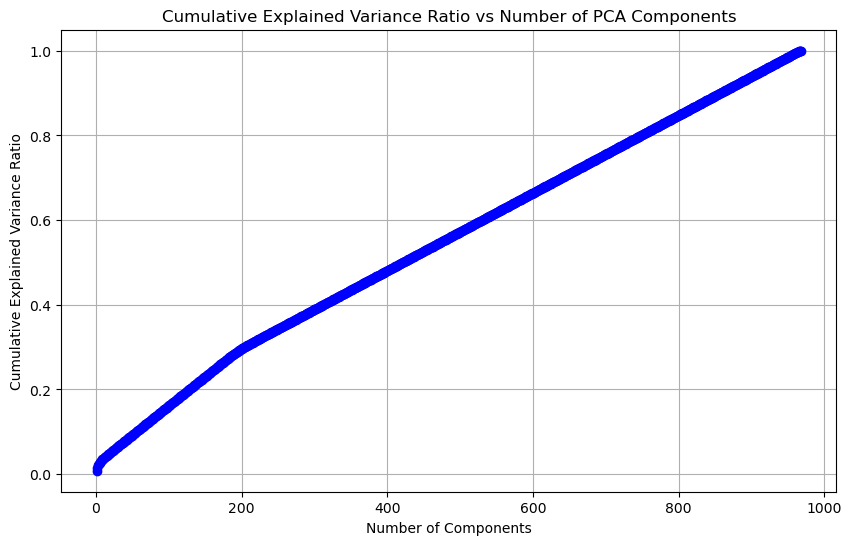

In [12]:
# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)
plt.show()

In [13]:
# Find number of components for 95% variance explained
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components explaining 95% of variance: {n_components_95}")

# Perform PCA with 95% explained variance
pca_95 = PCA(n_components=n_components_95)
X_pca_95 = pca_95.fit_transform(X_scaled)

print(f"Shape of PCA-transformed data (95% variance): {X_pca_95.shape}")

Number of components explaining 95% of variance: 912
Shape of PCA-transformed data (95% variance): (968, 912)


In [14]:
# Get feature names
feature_names = X.columns

# Create a DataFrame of feature loadings
loadings = pd.DataFrame(
    pca_95.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_95)],
    index=feature_names
)

# Print the top 10 features for the first 3 principal components
for i in range(3):
    print(f"\nTop 10 features in PC{i+1}:")
    print(loadings[f'PC{i+1}'].abs().sort_values(ascending=False).head(10))


Top 10 features in PC1:
sniping_rounds_with_kills_percentage    0.206995
sniping_kills_per_round                 0.205665
sniping_multi_kill_rounds               0.205606
sniping_score                           0.204642
sniping_kills_percentage                0.204071
opening_success                         0.202675
sniping_opening_kills_per_round         0.200080
kd_ratio                                0.191628
dpr                                     0.174935
deaths_per_round                        0.174935
Name: PC1, dtype: float64

Top 10 features in PC2:
firepower_damage_per_round_win      0.211863
trading_saved_teammate_per_round    0.198386
firepower_rounds_with_multi_kill    0.197993
damage_per_round                    0.197917
adr                                 0.197917
firepower_kills_per_round           0.197358
firepower_score                     0.194798
firepower_damage_per_round          0.190906
trading_kills_per_round             0.188715
firepower_rounds_with_kill   

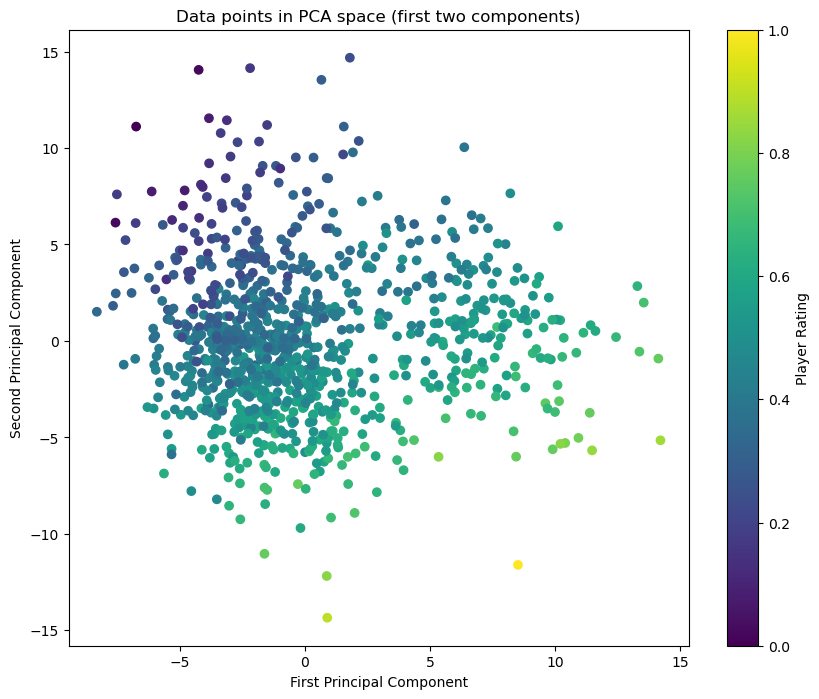

In [15]:
# Visualize the data points in PCA space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_95[:, 0], X_pca_95[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter, label='Player Rating')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Data points in PCA space (first two components)')
plt.show()

In [16]:
# Calculate correlations between PCA components and target
pca_df = pd.DataFrame(X_pca_95, columns=[f'PC{i+1}' for i in range(n_components_95)])
pca_df['rating'] = y

correlations = pca_df.corr()['rating'].abs().sort_values(ascending=False)
print("\nCorrelations between PCA components and player rating:")
print(correlations.head(10))  # Print top 10 correlations


Correlations between PCA components and player rating:
rating    1.000000
PC2       0.735928
PC1       0.540888
PC8       0.131716
PC205     0.082638
PC11      0.079604
PC10      0.076846
PC201     0.069968
PC203     0.069323
PC3       0.068708
Name: rating, dtype: float64


### Results

1. **Number of Components Explaining 95% of Variance**:  
   The PCA model shows that **912 components** are required to explain 95% of the variance in the dataset. This means that out of the original features, PCA has reduced the dataset to 912 components, preserving nearly all of the data's important variance while eliminating redundant information.

2. **PCA-Transformed Data Shape**:  
   The transformed data now has **968 rows and 912 columns**. Each column represents a principal component (PC), which is a linear combination of the original features.

3. **Top Features in Principal Components (PC1, PC2, PC3)**:  
   - **PC1** is strongly influenced by sniping-related features like `sniping_rounds_with_kills_percentage`, `sniping_kills_per_round`, and `sniping_score`. These features likely capture significant performance metrics in the first principal component.
   - **PC2** emphasizes features like `firepower_damage_per_round_win`, `trading_saved_teammate_per_round`, and `damage_per_round`, indicating that firepower and trading-related statistics are key factors in this component.
   - **PC3** is heavily impacted by features like `entrying_support_rounds`, `trading_kills_percentage`, and `utility_flash_assists_per_round`, highlighting the importance of team support and utility usage in the third principal component.

4. **Correlations Between PCA Components and Player Rating**:  
   The correlation between each principal component and player rating reveals the following insights:
   - **PC2** shows the highest correlation (0.735928) with player rating, meaning that the features captured in this component are the most strongly related to player performance.
   - **PC1** also has a strong positive correlation (0.540888), indicating that it captures important performance-related features.
   - Other components such as **PC8**, **PC205**, and **PC3** show weaker correlations but still contribute some predictive value regarding player rating.

These results suggest that the most important features in the dataset are captured in a few principal components, which are strongly correlated with the target (player rating). This helps in focusing on the most impactful factors while reducing dimensionality for further analysis or modeling.

In [17]:
# First, let's check the 'age' column
print("Age column diagnostics:")
print(f"Data type: {X['age'].dtype}")
print(f"Number of unique values: {X['age'].nunique()}")
print(f"Number of NaN values: {X['age'].isna().sum()}")
print(f"Min value: {X['age'].min()}")
print(f"Max value: {X['age'].max()}")
print(f"Mean value: {X['age'].mean()}")
print(f"Amount of datapoints with age {X['age'].count()}")

Age column diagnostics:
Data type: int64
Number of unique values: 1
Number of NaN values: 0
Min value: 23
Max value: 23
Mean value: 23.0
Amount of datapoints with age 968


In [18]:
# Multicollinearity Check (VIF)
def calculate_vif(X):
    # Identify non-binary columns
    non_binary_cols = X.columns[X.nunique() > 2]
    
    # Standardize the features
    X_scaled = StandardScaler().fit_transform(X[non_binary_cols])
    
    # Calculate VIF for non-binary columns
    vif_data = pd.DataFrame()
    vif_data["feature"] = non_binary_cols
    vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    
    # Sort by VIF values
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    return vif_data

vif_results = calculate_vif(X)
print("VIF Results for non-binary columns:")
print(vif_results)

# For binary columns, check their correlation with other features
binary_cols = X.columns[X.nunique() == 2]
if len(binary_cols) > 0:
    print("\nCorrelation of binary columns with other features:")
    correlation_matrix = X.corr()
    for col in binary_cols:
        print(f"\nCorrelations for {col}:")
        print(correlation_matrix[col].sort_values(ascending=False).drop(col))

c:\Users\Chaos\anaconda3\envs\dev\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Results for non-binary columns:
                              feature       VIF
0                                 dpr       inf
1                                 kpr       inf
15                   damage_per_round       inf
4                                 adr       inf
11                   deaths_per_round       inf
..                                ...       ...
33            clutch_points_per_round  3.660090
30  win_percentage_after_opening_kill  1.542170
48  trading_assisted_kills_percentage  1.404340
34         clutch_1on1_win_percentage  1.231258
35        clutch_time_alive_per_round  1.047095

[63 rows x 2 columns]

Correlation of binary columns with other features:

Correlations for player_name_0i:
real_name_ZhiWei Liu                 1.000000
dpr                                  0.047629
deaths_per_round                     0.047629
team_no team                         0.039743
headshot_percentage                  0.035841
                                       ...   
ent

In [19]:
# Mutual Information
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:")
print(mi_scores)

Mutual Information Scores:
kd_ratio                      0.874832
kpr                           0.740670
kills_per_round               0.711247
firepower_score               0.543491
firepower_rounds_with_kill    0.536227
                                ...   
player_name_Valiance          0.000000
player_name_Vegi              0.000000
player_name_Vexite            0.000000
real_name_Derek Brown         0.000000
real_name_Arthur Schmitt      0.000000
Length: 2183, dtype: float64


In [22]:
# Stability Selection
from sklearn.utils import resample

def stability_selection(X, y, n_iterations=100, sample_fraction=0.75, n_estimators=100):
    feature_importances = np.zeros(X.shape[1])
    for _ in range(n_iterations):
        X_sample, y_sample = resample(X, y, n_samples=int(len(X) * sample_fraction))
        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        rf.fit(X_sample, y_sample)
        feature_importances += rf.feature_importances_
    return pd.Series(feature_importances / n_iterations, index=X.columns).sort_values(ascending=False)

stability_scores = stability_selection(X, y)
print("\nStability Selection Scores:")
print(stability_scores)


Stability Selection Scores:
kd_ratio                           6.309043e-01
firepower_damage_per_round_win     7.386913e-02
kills_per_round                    4.459179e-02
kpr                                4.335020e-02
firepower_score                    2.222484e-02
                                       ...     
player_name_asap                   4.201092e-08
real_name_Christopher Fernandes    3.676758e-08
player_name_NBK-                   3.091310e-08
real_name_Robin Rönnquist          2.854861e-08
age                                0.000000e+00
Length: 2183, dtype: float64
